In [38]:
!pip install pandas matplotlib yfinance numpy

import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf # https://github.com/ranaroussi/yfinance
import numpy as np

In [39]:
# Import data
green_stocks = pd.read_csv('green_stocks.csv')
green_stocks.head()

,Name,Ticker,Category,ETF
0,Brookfield Renewable Partners,BEP,power_hydro,NaN
1,General Electric,GE,power_wind,NaN
2,NextEra Energy Partners,NEP,power_wind,NaN
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN
4,Vestas Wind Systems,VWDRY,power_wind,NaN


<AxesSubplot:>

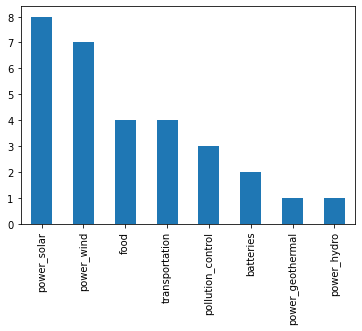

In [40]:
# Understand distribution of stock data
green_stocks['Category'].value_counts().plot(kind='bar')

<AxesSubplot:>

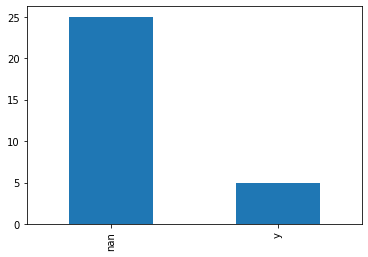

In [41]:
green_stocks['ETF'].value_counts(dropna=False).plot(kind='bar')

In [42]:
# Example Yahoo Finance query based on ticker symbol of 'BEP'
BEP = yf.Ticker('BEP')

In [43]:
BEP.info['longBusinessSummary']

'Brookfield Renewable Partners L.P. owns a portfolio of renewable power generating facilities primarily in North America, Colombia, Brazil, Europe, India, and China. The company generates electricity through hydroelectric, wind, solar, distributed generation, pumped storage, cogeneration, and biomass sources. Its portfolio consists of approximately 19,000 megawatts of installed capacity. Brookfield Renewable Partners Limited operates as the general partner of Brookfield Renewable Partners L.P. The company was formerly known as Brookfield Renewable Energy Partners L.P. and changed its name to Brookfield Renewable Partners L.P. in May 2016. Brookfield Renewable Partners L.P. was founded in 1999 and is based in Toronto, Canada.'

In [44]:
BEP.info['website']

'http://www.bep.brookfield.com'

In [46]:
# Get stock data for all green stocks

stock_descriptions = []
stock_websites = []

def get_stock_description(ticker):
    stock = yf.Ticker(ticker)
    # Descriptive information
    try:
        description = stock.info['longBusinessSummary']
        website = stock.info['website']
    except:
        description = np.nan
        website = np.nan
        print(f'No stock with {ticker} ticker symbol...')
    stock_descriptions.append(description)
    stock_websites.append(website)

In [47]:
green_stocks['Ticker'].apply(get_stock_description)

green_stocks = pd.concat([green_stocks,pd.Series(stock_descriptions, name='Description')], axis=1).copy()
green_stocks = pd.concat([green_stocks,pd.Series(stock_websites, name='Website')], axis=1).copy()

No stock with FAN ticker symbol...
No stock with VSLR ticker symbol...
No stock with TAN ticker symbol...
No stock with EVX ticker symbol...
No stock with PZD ticker symbol...
No stock with DRIV ticker symbol...


In [49]:
# Clean up stocks with missing description / websites (indicating no data in Yahoo Finance)
# These are mostly ETFs
green_stocks = green_stocks.dropna(subset=['Description', 'Website'])
green_stocks

,Name,Ticker,Category,ETF,Description,Website
0,Brookfield Renewable Partners,BEP,power_hydro,NaN,Brookfield Renewable Partners L.P. owns a port...,http://www.bep.brookfield.com
1,General Electric,GE,power_wind,NaN,General Electric Company operates as a high-te...,http://www.ge.com
2,NextEra Energy Partners,NEP,power_wind,NaN,"NextEra Energy Partners, LP acquires, owns, an...",http://www.investor.nexteraenergypartners.com
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN,"Siemens Gamesa Renewable Energy, S.A., togethe...",http://www.siemensgamesa.com
4,Vestas Wind Systems,VWDRY,power_wind,NaN,"Vestas Wind Systems A/S designs, manufactures,...",http://www.vestas.com
6,First Solar,FSLR,power_solar,NaN,"First Solar, Inc. provides photovoltaic (PV) s...",http://www.firstsolar.com
7,JinkoSolar Holding,JKS,power_solar,NaN,"JinkoSolar Holding Co., Ltd., together with it...",http://www.jinkosolar.com
8,Sunpower,SPWR,power_solar,NaN,SunPower Corporation delivers solar solutions ...,http://us.sunpower.com
9,Enphase Energy,ENPH,power_solar,NaN,"Enphase Energy, Inc., together with its subsid...",http://www.enphase.com
10,Sunrun,RUN,power_solar,NaN,"Sunrun Inc. engages in the design, development...",http://www.sunrun.com
